# Mie Scattering Efficiencies

**Scott Prahl**

**Jan 2025**

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib.resources

if sys.platform == "emscripten":
    import piplite

    await piplite.install("miepython")
    os.environ["MIEPYTHON_USE_JIT"] = "0"  # jupyterlite cannot use numba

import miepython as mie

When a monochromatic plane wave is incident on a sphere, it scatters and absorbs light depending on the properties of the light and sphere.  The sphere has radius $r$ and index of refraction $m=m_\mathrm{re}- j\,m_\mathrm{im}$.  The sphere size parameter $x=2\pi x/\lambda$ where $\lambda$ is the wavelength of the plane wave in a vacuum.

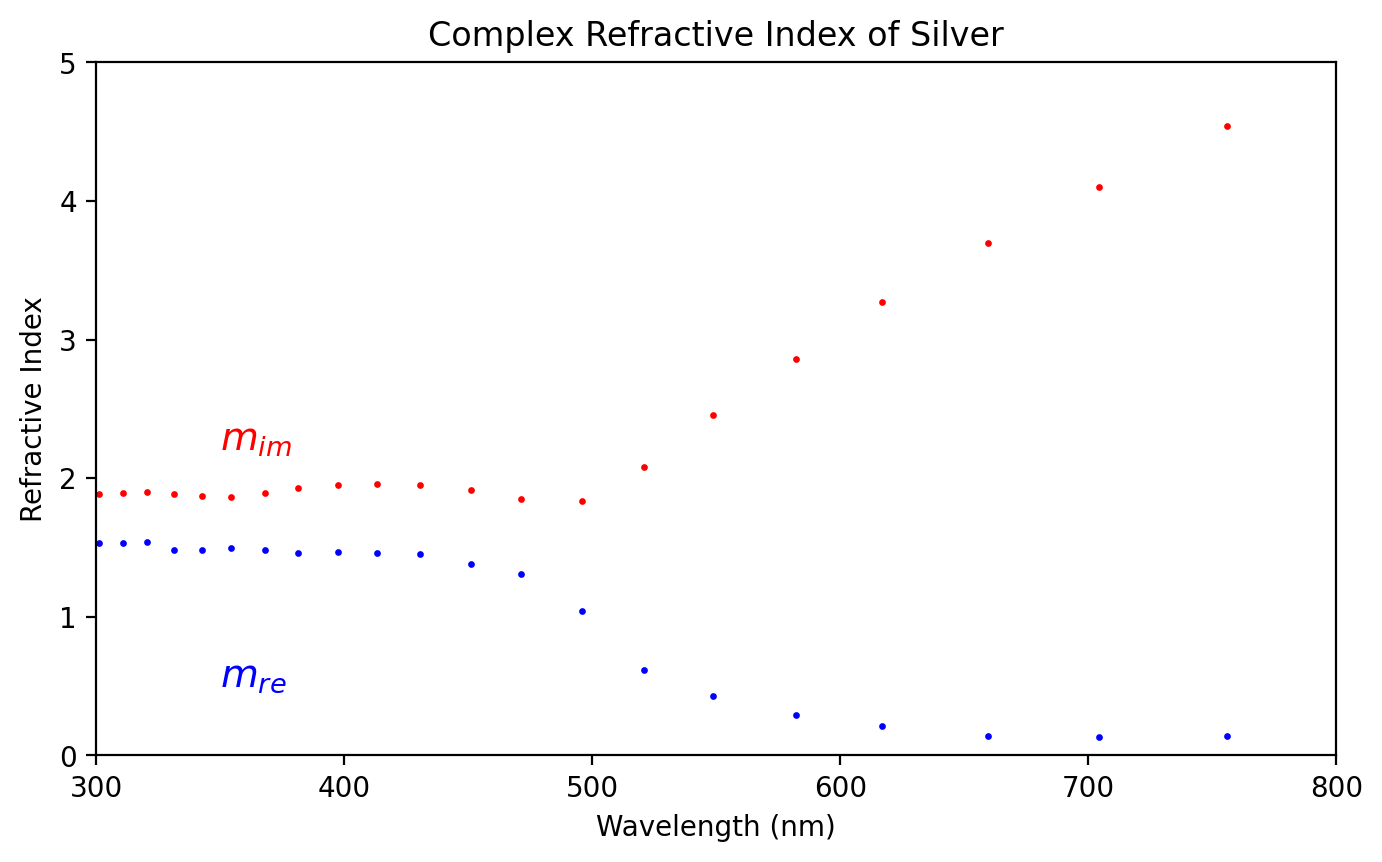

In [2]:
# import the Johnson and Christy data for silver
# ag = np.genfromtxt('https://refractiveindex.info/tmp/data/main/Ag/Johnson.txt', delimiter='\t')

nname = "data/Johnson.txt"
ref = importlib.resources.files("miepython").joinpath(nname)
ag = np.genfromtxt(ref, delimiter="\t")

# data is stacked so need to rearrange
N = len(ag) // 2
ag_lam = ag[1:N, 0]
ag_mre = ag[1:N, 1]
ag_mim = ag[N + 1 :, 1]

plt.figure(figsize=(8, 4.5))
plt.scatter(ag_lam * 1000, ag_mre, s=2, color="blue")
plt.scatter(ag_lam * 1000, ag_mim, s=2, color="red")
plt.xlim(300, 800)
plt.ylim(0, 5)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Refractive Index")
plt.text(350, 0.5, "$m_{re}$", color="blue", fontsize=14)
plt.text(350, 2.2, "$m_{im}$", color="red", fontsize=14)

plt.title("Complex Refractive Index of Silver")

plt.show()

## Efficiencies

`miepython.mie(m,x)` calculates three dimensionless efficiencies for a sphere with complex index of refraction $m$ and dimensionless size parameter $x$:

- $Q_{ext}$ the extinction efficiency 
- $Q_{sca}$ the scattering efficiency 
- $Q_{back}$ the back-scattering efficiency 

as well as the dimensionless average cosine of the scattering angle

- $g$ scattering anisotropy.

## Cross Sections

Scattering and absorption cross sections $\sigma$ have units of area and can be obtained from the efficiencies by multiplying by the geometric cross section $\pi r^2$ of the sphere.  

$$
\sigma_\mathrm{sca} = \pi r^2 Q_\mathrm{sca}
$$

$$
\sigma_\mathrm{ext} = \pi r^2 Q_\mathrm{ext}
$$

$$
\sigma_\mathrm{back} = \pi r^2 Q_\mathrm{back}
$$

For example, the scattering cross section $\sigma_\mathrm{sca}$ is *effective* area of a the incident plane wave that interacts and produces scattered light.  

Since some of the incident light may be absorbed (when $m_\mathrm{im}$ is non-zero) then there is also an area of the incident wave that is absorbed $\sigma_\mathrm{abs}$.  

$$
Q_\mathrm{ext} = Q_\mathrm{abs}+Q_\mathrm{sca}
$$

and so

$$
\sigma_\mathrm{abs} = \sigma_\mathrm{ext}-\sigma_\mathrm{sca}
$$

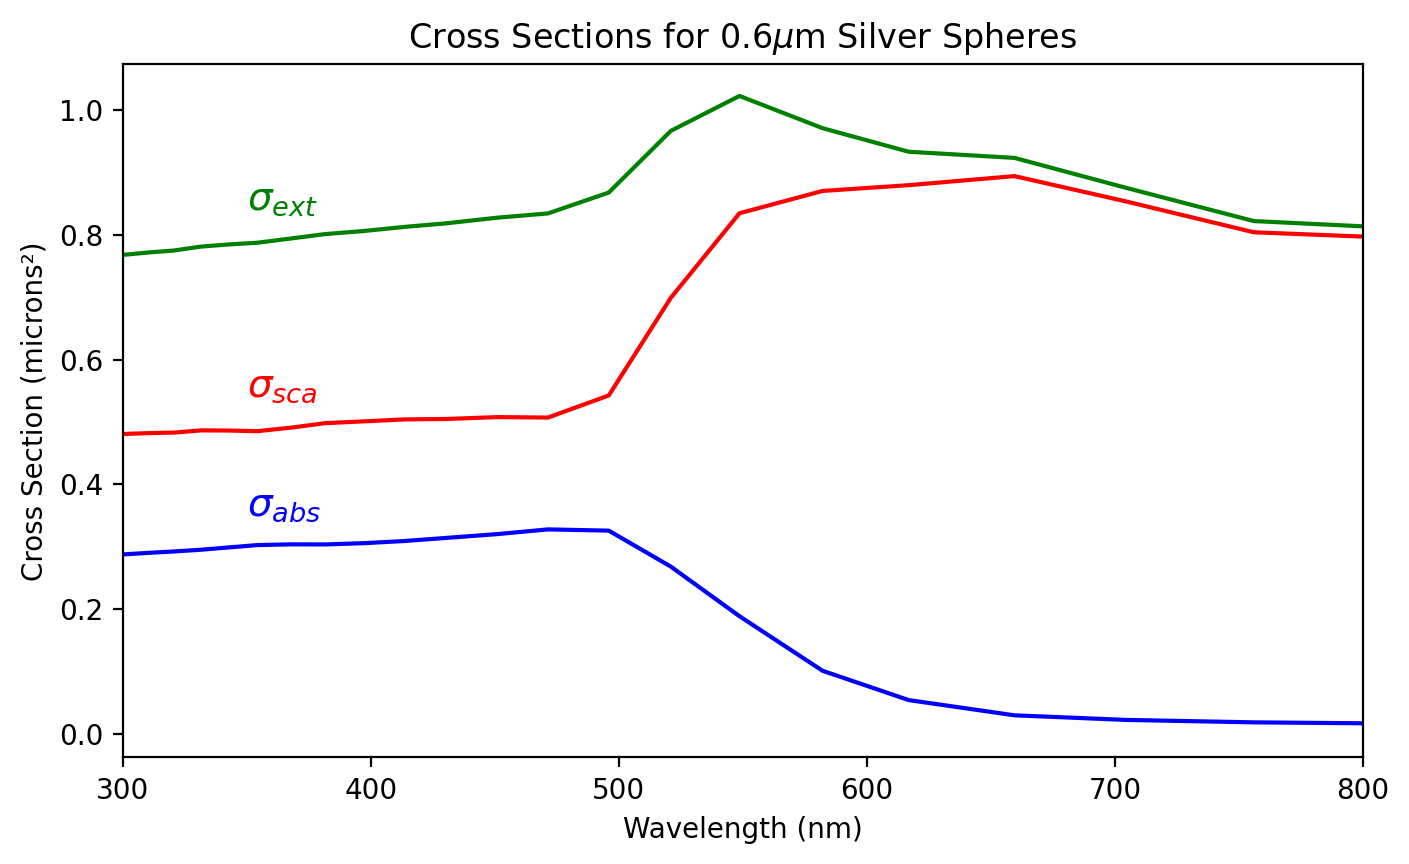

In [3]:
r = 0.3  # radius in microns
geometric_cross_section = np.pi * r**2

x = 2 * np.pi * r / ag_lam
m = ag_mre - 1.0j * ag_mim

qext, qsca, qback, g = mie.efficiencies_mx(m, x)
absorb = (qext - qsca) * geometric_cross_section
scatt = qsca * geometric_cross_section
extinct = qext * geometric_cross_section

plt.figure(figsize=(8, 4.5))
plt.plot(ag_lam * 1000, absorb, color="blue")
plt.plot(ag_lam * 1000, scatt, color="red")
plt.plot(ag_lam * 1000, extinct, color="green")
plt.text(350, 0.35, r"$\sigma_{abs}$", color="blue", fontsize=14)
plt.text(350, 0.54, r"$\sigma_{sca}$", color="red", fontsize=14)
plt.text(350, 0.84, r"$\sigma_{ext}$", color="green", fontsize=14)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Cross Section (microns²)")
plt.title(r"Cross Sections for %.1f$\mu$m Silver Spheres" % (r * 2))

plt.xlim(300, 800)
plt.show()

## Scattering and absorption coefficients

The scattering cross section may be related to the transmission of a beam 
through a dispersion of scatterers of equal size.  For $\rho$ particles per
unit volume, the attenuation due to scattering is

$$
-\frac{dI}{dx} = \rho \sigma_\mathrm{sca} I
$$

The transmission is

$$
T = I/I_0 = \exp(-\rho \sigma_\mathrm{sca} x) = \exp(-\mu_s x)
$$

and the coefficients for a sphere with radius r is

$$
\mu_\mathrm{sca} = \rho \sigma_\mathrm{sca} = \rho \pi r^2 Q_\mathrm{sca}
$$

$$
\mu_\mathrm{ext} = \rho \sigma_\mathrm{ext} = \rho \pi r^2 Q_\mathrm{ext}
$$

$$
\mu_\mathrm{abs} = \rho \sigma_\mathrm{abs} = \rho \pi r^2 (Q_\mathrm{ext}-Q_\mathrm{sca})
$$

[Kerker, p. 38](https://www.sciencedirect.com/book/9780124045507/the-scattering-of-light-and-other-electromagnetic-radiation).

## Backscattering Cross Section

For plane-wave radiation incident on a scattering object or a scattering medium, the ratio of the intensity [W/sr] scattered in the direction toward the source to the incident irradiance [W/area].

1. So defined, the backscattering cross section has units of area per unit solid angle.

2. In common usage, synonymous with radar cross section, although this can be confusing because the radar cross section is $4\pi$ times the backscattering cross section as defined above and has units of area.

If $Q_{sca}$ [unitless] is the backscattering efficiency then the scattering cross section $\sigma_\mathrm{sca}$ [area]

$$
\sigma_\mathrm{sca} = \pi r^2 Q_{sca}
$$

Thus if $Q_{back}$ [unitless] is the backscattering efficiency then the scattering cross section $\sigma_\mathrm{back}$ [area]

$$
\sigma_\mathrm{back} = \pi r^2 Q_{back}
$$

Now the phase function is normalized to one ($S_1(\theta)$ has units of sr$^{-0.5}$)

$$
\int_{4\pi} \frac{|S_1(\theta)|^2+|S_2(\theta)|^2)}{2}\,d\Omega =1
$$

Now since

$$
|S_1(-180^\circ)|^2=|S_2(-180^\circ)|^2=|S_1(180^\circ)|^2=|S_2(180^\circ)|^2
$$

The differential scattering cross section [area/sr] in the backwards direction will be

$$
\left. \frac{d\sigma_\mathrm{sca}}{d\Omega}\right|_{180^\circ} =\sigma_\mathrm{sca} |S_1(-180^\circ)|^2
$$

and the backscattering cross section will be $4\pi$ times this

$$
\sigma_\mathrm{back} = 4\pi \left. \frac{d\sigma_\mathrm{sca}}{d\Omega}\right|_{180^\circ} = 4\pi \sigma_\mathrm{sca} |S_1(-180^\circ)|^2
$$

In [4]:
lambda0 = 1  # microns
a = lambda0 / 10  # also microns
k = 2 * np.pi / lambda0  # per micron

m = 1.5
x = a * k
geometric_cross_section = np.pi * a**2

theta = np.linspace(-180, 180, 180)
mu = np.cos(theta / 180 * np.pi)
s1, s2 = mie.S1_S2(m, x, mu)
phase = (abs(s1[0]) ** 2 + abs(s2[0]) ** 2) / 2

print("     unpolarized =", phase)
print("   |s1[-180]|**2 =", abs(s1[0] ** 2))
print("   |s2[-180]|**2 =", abs(s2[0] ** 2))
print("   |s1[ 180]|**2 =", abs(s1[179] ** 2))
print("   |s2[ 180]|**2 =", abs(s2[179] ** 2))
print()

qext, qsca, qback, g = mie.efficiencies_mx(m, x)

Cback = qback * geometric_cross_section
Csca = qsca * geometric_cross_section

print("            Csca =", Csca)
print("           Cback =", Cback)
print("4*pi*Csca*p(180) =", 4 * np.pi * Csca * phase)

     unpolarized = 0.09847897662479224
   |s1[-180]|**2 = 0.09847897662479226
   |s2[-180]|**2 = 0.09847897662479226
   |s1[ 180]|**2 = 0.09847897662479226
   |s2[ 180]|**2 = 0.09847897662479226

            Csca = 0.0011392154570612698
           Cback = 0.0014098056923279043
4*pi*Csca*p(180) = 0.0014098056923279034


## Efficiencies

To create a non-dimensional quantity, the scattering efficiency may be defined as

$$
Q_\mathrm{sca} = \frac{\sigma_\mathrm{sca}}{ \pi r^2}
$$

where the scattering cross section is normalized by the geometric cross section.  Thus when the scattering efficiency is unity, then the portion of the incident plane wave that is affected is equal to the cross sectional area of the sphere.  

Similarly the absorption efficiency

$$
Q_\mathrm{abs} = \frac{\sigma_\mathrm{abs}}{ \pi r^2}
$$

And finally the extinction cross section is

$$
Q_{ext}=Q_{sca}+Q_{abs}
$$

where $Q_{sca}$ is the scattering efficiency and $Q_{abs}$ is the absorption
efficiency.  $Q_{sca}$ and $Q_{ext}$ are determined by the
Mie scattering program and $Q_{abs}$ is obtained by subtraction.  

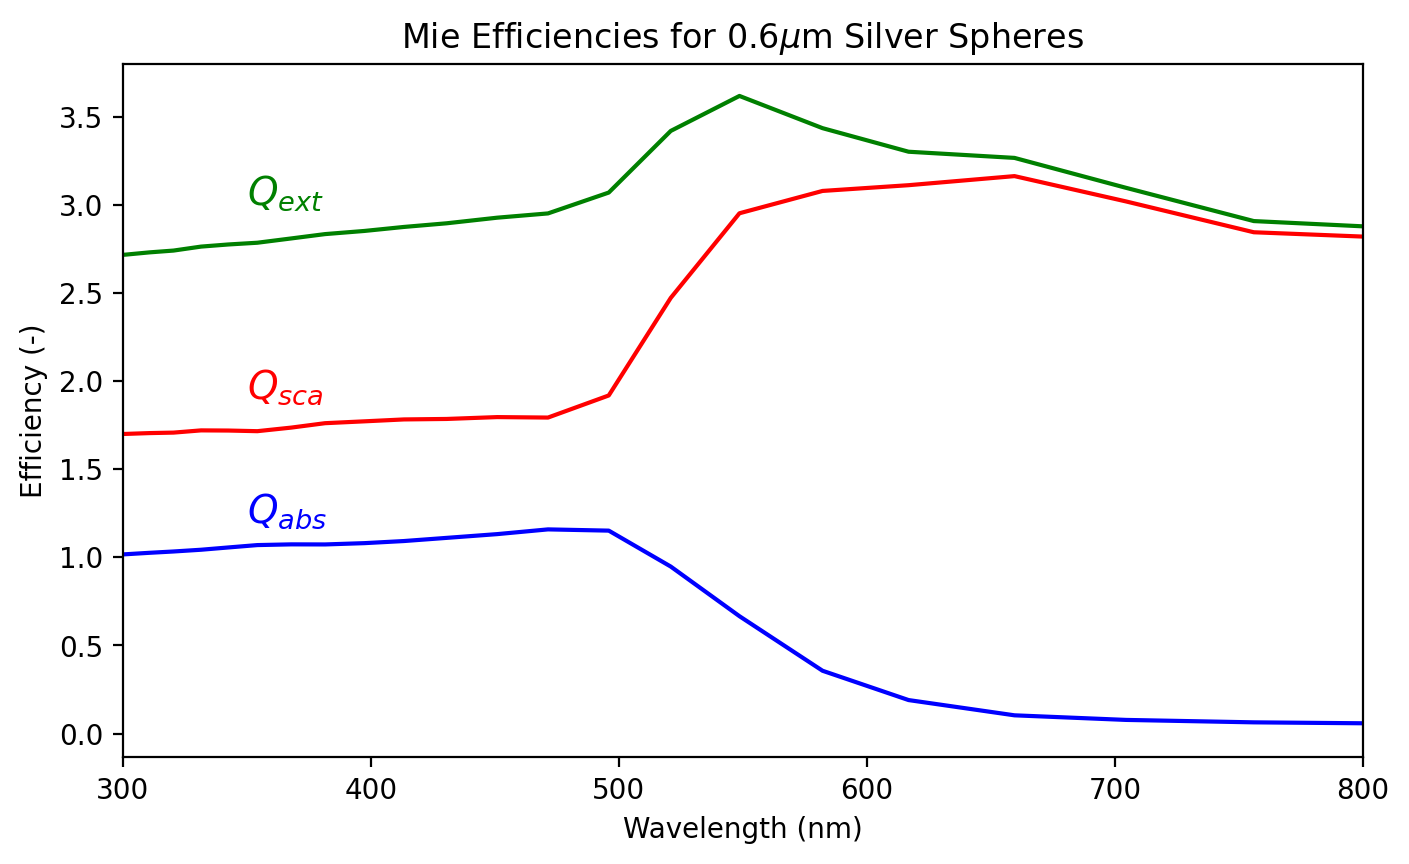

In [5]:
r = 0.3  # radius in microns

x = 2 * np.pi * r / ag_lam
m = ag_mre - 1.0j * ag_mim
qext, qsca, qback, g = mie.efficiencies_mx(m, x)

plt.figure(figsize=(8, 4.5))
plt.plot(ag_lam * 1000, qext - qsca, color="blue")
plt.plot(ag_lam * 1000, qsca, color="red")
plt.plot(ag_lam * 1000, qext, color="green")
plt.text(350, 1.2, "$Q_{abs}$", color="blue", fontsize=14)
plt.text(350, 1.9, "$Q_{sca}$", color="red", fontsize=14)
plt.text(350, 3.0, "$Q_{ext}$", color="green", fontsize=14)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Efficiency (-)")
plt.title(r"Mie Efficiencies for %.1f$\mu$m Silver Spheres" % (r * 2))
plt.xlim(300, 800)
plt.show()

## Radiation Pressure

The radiation pressure is given by [e.g., Kerker, p. 94]

$$
Q_\mathrm{pr}=Q_\mathrm{ext}-g Q_\mathrm{sca}
$$

and is the momentum given to the scattering particle [van de Hulst, p. 13] in the direction of the incident wave. The radiation pressure cross section $\sigma_\mathrm{pr}$ is just the efficiency multiplied by the geometric cross section

$$
\sigma_\mathrm{pr} = \pi r^2 Q_\mathrm{pr}
$$

The radiation pressure cross section $\sigma_\mathrm{pr}$ can be interpreted as the area of a black wall that would receive the same force from the same incident wave.  The actual force on the particle is

$$
F = E_0 \frac{\sigma_\mathrm{pr}}{c}
$$

where $E_0$ is the irradiance (W/m$^2$) on the sphere and $c$ is the velocity of the radiation in the medium.  If the irradiance has N photons per geometric cross section ($\pi r^2$) then this can be rewritten as

$$
F = N \frac{h}{\lambda} \sigma_\mathrm{pr} = N \cdot \mbox{(photon momentum)} \cdot \sigma_\mathrm{pr}
$$

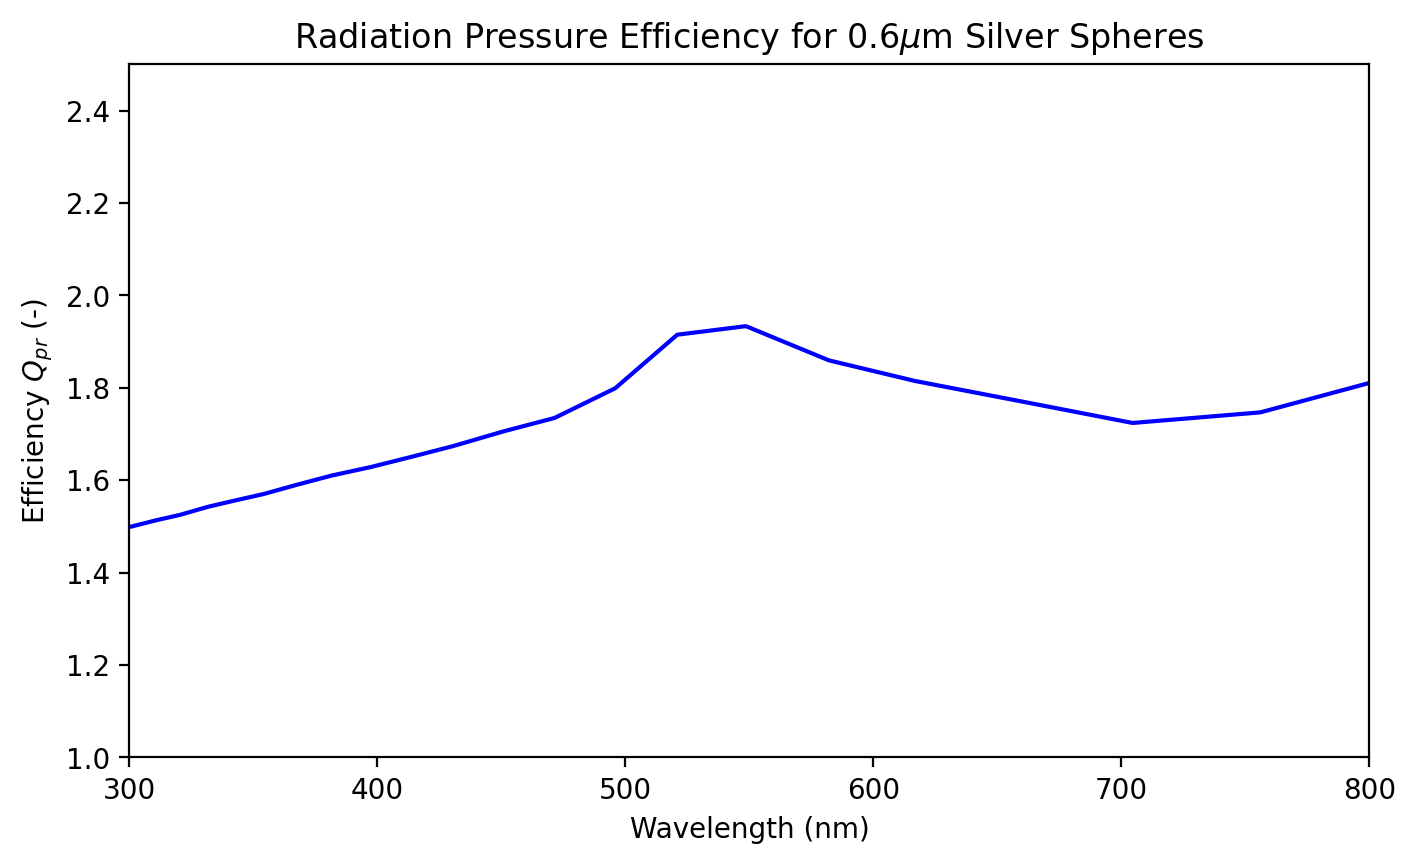

In [6]:
r = 0.3  # radius in microns

x = 2 * np.pi * r / ag_lam
m = ag_mre - 1.0j * ag_mim
qext, qsca, qback, g = mie.efficiencies_mx(m, x)
qpr = qext - g * qsca

plt.figure(figsize=(8, 4.5))
plt.plot(ag_lam * 1000, qpr, color="blue")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Efficiency $Q_{pr}$ (-)")
plt.title(r"Radiation Pressure Efficiency for %.1f$\mu$m Silver Spheres" % (r * 2))
plt.xlim(300, 800)
plt.ylim(1, 2.5)
plt.show()

## Graph of backscattering efficiency

van de Hulst has a nice graph of backscattering efficiency that we can replicate

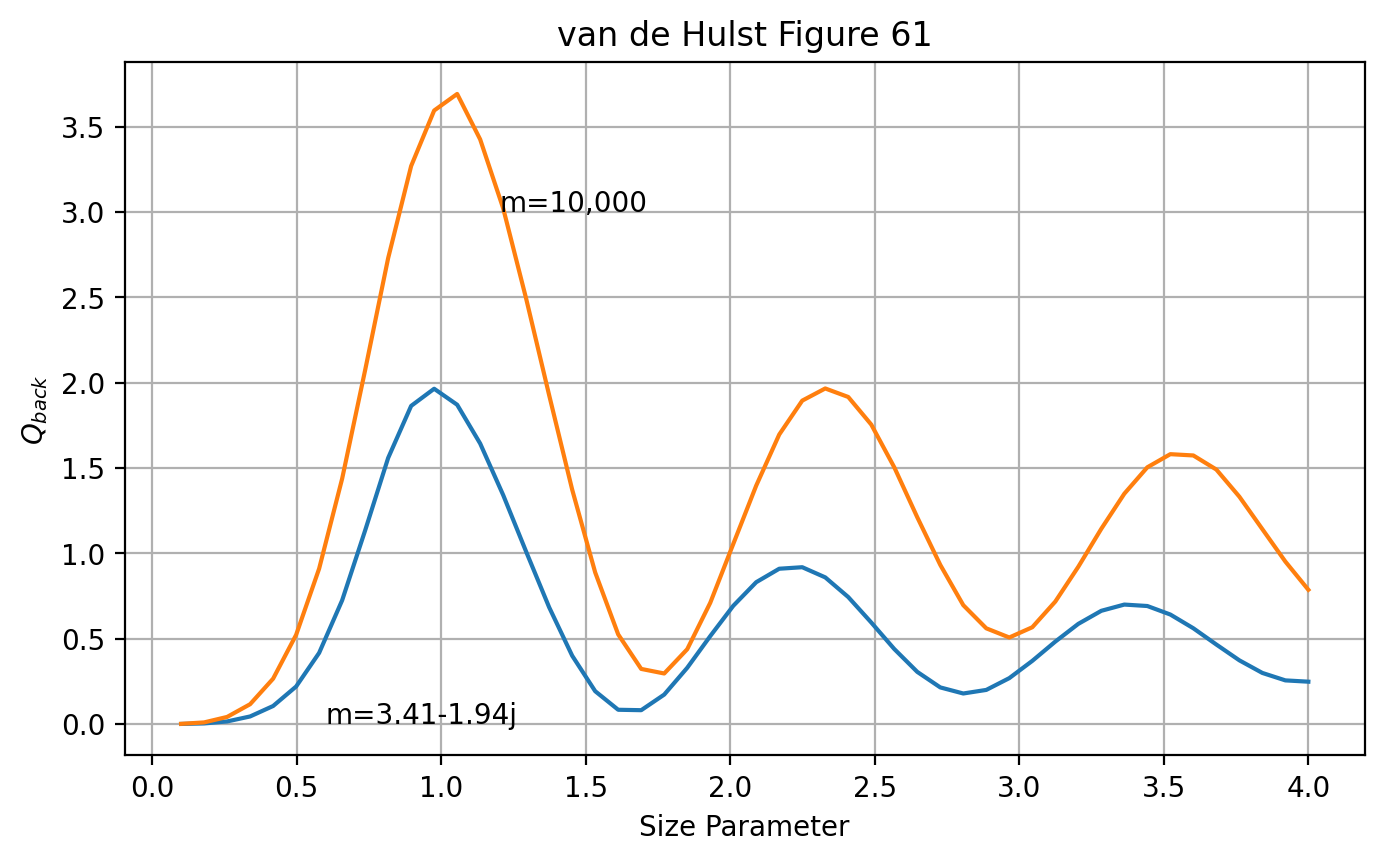

In [7]:
x = np.linspace(0.1, 4, 50)

m = 3.41 - 1.94j
qext, qsca, qback, g = mie.efficiencies_mx(m, x)
plt.figure(figsize=(8, 4.5))
plt.plot(x, qback)
plt.text(0.6, 0, "m=3.41-1.94j")

m = 10000
qext, qsca, qback, g = mie.efficiencies_mx(m, x)
plt.plot(x, qback)
plt.text(1.2, 3.0, "m=10,000")

plt.xlabel("Size Parameter")
plt.ylabel(r"$Q_{back}$")
plt.title("van de Hulst Figure 61")
plt.grid(True)
plt.show()